In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/ashrae_db2.01.csv")

<ipython-input-2-a9437d0b165b>:1: DtypeWarning: Columns (10,11,13,18,19,34,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/ashrae_db2.01.csv")


In [ ]:
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

In [ ]:
drop_cols = [
    "Publication (Citation)", "Data contributor", "Database",
    "Air temperature (F)", "Operative temperature (F)", "Radiant temperature (F)",
    "Globe temperature (F)", "Tg_h (F)", "Tg_m (F)", "Tg_l (F)",
    "Velocity_h (fpm)", "Velocity_m (fpm)", "Velocity_l (fpm)", "Air velocity (fpm)",
    "Outdoor monthly air temperature (F)"]

In [ ]:
df = df.drop(columns=[col for col in drop_cols if col in df.columns])


In [ ]:
df = df.dropna(subset=["Thermal sensation", "Air temperature (C)", "Relative humidity (%)"])

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())

In [ ]:
target_col = "PMV"
X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
categorical_cols = X.select_dtypes(include="object").columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
class ThermalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_data = ThermalDataset(X_train_scaled, y_train)
test_data = ThermalDataset(X_test_scaled, y_test)

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

In [ ]:
class ThermalRegressor(nn.Module):
    def __init__(self, input_dim):
        super(ThermalRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(200,200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(200,200),
            nn.ReLU(),

            nn.Linear(200, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model = ThermalRegressor(X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


Epoch 1/100, Loss: 0.0553
Epoch 2/100, Loss: 0.0261
Epoch 3/100, Loss: 0.0191
Epoch 4/100, Loss: 0.0172
Epoch 5/100, Loss: 0.0149
Epoch 6/100, Loss: 0.0130
Epoch 7/100, Loss: 0.0122
Epoch 8/100, Loss: 0.0108
Epoch 9/100, Loss: 0.0105
Epoch 10/100, Loss: 0.0100
Epoch 11/100, Loss: 0.0095
Epoch 12/100, Loss: 0.0092
Epoch 13/100, Loss: 0.0089
Epoch 14/100, Loss: 0.0084
Epoch 15/100, Loss: 0.0088
Epoch 16/100, Loss: 0.0082
Epoch 17/100, Loss: 0.0078
Epoch 18/100, Loss: 0.0078
Epoch 19/100, Loss: 0.0075
Epoch 20/100, Loss: 0.0071
Epoch 21/100, Loss: 0.0075
Epoch 22/100, Loss: 0.0075
Epoch 23/100, Loss: 0.0070
Epoch 24/100, Loss: 0.0070
Epoch 25/100, Loss: 0.0070
Epoch 26/100, Loss: 0.0069
Epoch 27/100, Loss: 0.0067
Epoch 28/100, Loss: 0.0065
Epoch 29/100, Loss: 0.0064
Epoch 30/100, Loss: 0.0062
Epoch 31/100, Loss: 0.0063
Epoch 32/100, Loss: 0.0062
Epoch 33/100, Loss: 0.0061
Epoch 34/100, Loss: 0.0058
Epoch 35/100, Loss: 0.0060
Epoch 36/100, Loss: 0.0060
Epoch 37/100, Loss: 0.0056
Epoch 38/1

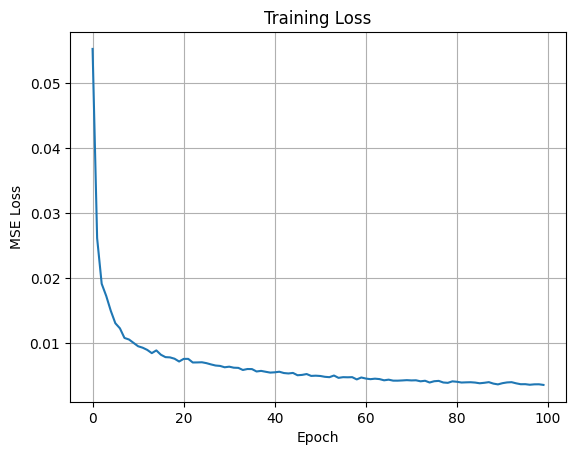

In [ ]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

In [ ]:
model.eval()

ThermalRegressor(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): ReLU()
    (10): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [ ]:
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        predictions.extend(preds)
        actuals.extend(yb.numpy())

In [ ]:
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"\n✅ Final RMSE on Test Set: {rmse:.4f}")


✅ Final RMSE on Test Set: 0.1232


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# R2 Score
r2 = r2_score(actuals, predictions)
print(f"R² Score: {r2:.4f}")

# MAE
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# RMSE (already printed, repeating here for clarity)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


R² Score: 0.9760
Mean Absolute Error (MAE): 0.0641
Root Mean Squared Error (RMSE): 0.1232


Lets cross verify using cross validation

In [ ]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

rmse_list = []
r2_list = []
mae_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    print(f"\n🔁 Fold {fold+1}/{k}")

    # Split data for this fold
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # PyTorch datasets
    train_data = ThermalDataset(X_train_fold, y_train_fold)
    val_data = ThermalDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=128)

    # Initialize new model for each fold
    model = ThermalRegressor(X_train_fold.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model
    for epoch in range(30):  # Use fewer epochs per fold
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            predictions.extend(preds)
            actuals.extend(yb.numpy())

    # Metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print(f"✅ Fold {fold+1} - RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")

    rmse_list.append(rmse)
    r2_list.append(r2)
    mae_list.append(mae)

# Final averaged results
print("\n📊 Cross-Validation Results:")
print(f"Average RMSE: {np.mean(rmse_list):.4f}")
print(f"Average R²: {np.mean(r2_list):.4f}")
print(f"Average MAE: {np.mean(mae_list):.4f}")



🔁 Fold 1/5
✅ Fold 1 - RMSE: 0.0839, R²: 0.9889, MAE: 0.0488

🔁 Fold 2/5
✅ Fold 2 - RMSE: 0.0667, R²: 0.9931, MAE: 0.0422

🔁 Fold 3/5
✅ Fold 3 - RMSE: 0.0620, R²: 0.9941, MAE: 0.0397

🔁 Fold 4/5
✅ Fold 4 - RMSE: 0.1116, R²: 0.9802, MAE: 0.0675

🔁 Fold 5/5
✅ Fold 5 - RMSE: 0.0902, R²: 0.9871, MAE: 0.0547

📊 Cross-Validation Results:
Average RMSE: 0.0829
Average R²: 0.9887
Average MAE: 0.0506
